# Seq2seq

Implementation of seq2seq model with attention from https://www.tensorflow.org/tutorials/text/nmt_with_attention

To run this notebook, you only need to have the file train.lang1 and train.lang2 in a Google Drive directory

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

#import unicodedata
import re
import numpy as np
import os
import time

In [0]:
tf.random.set_seed(0)
np.random.seed(0)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# Mounting colab with google drive
# In my Drive I have data folder containing train.lang1 and train.lang2

%cd /content/gdrive/My Drive/ift6759

/content/gdrive/My Drive/ift6759


## Preprocessing

In [0]:
# design decision included here, decided to keep é, è, ê, etc. for french 
# since otherwise it would divide a word like 'événementiel' into "v", "nementiel"

def preprocess_sentence(w):
  w = w.lower().strip()

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "é", "è", "ê", "ç", "î", "ï", "ô", "à", "û")
  w = re.sub(r"[^a-zA-Z?.!,¿éèçêîôïàû]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [5]:
fr_sentence = f"J'aime beaucoup le chocolat!"
en_sentence = f"I really like chocolate!"
print(preprocess_sentence(fr_sentence))
print(preprocess_sentence(en_sentence))

<start> j aime beaucoup le chocolat ! <end>
<start> i really like chocolate ! <end>


In [0]:
# mapping english sentences to french sentences
def combine_files(path_to_en_file, path_to_fr_file, output_path):
  with open(path_to_en_file, 'r') as en:
    with open(path_to_fr_file, 'r') as fr:
      with open(output_path, 'w') as outfile:
        en_lines = en.readlines()
        fr_lines = fr.readlines()
        for i in range(len(en_lines)):
          line = en_lines[i].strip() + '\t' + fr_lines[i]
          outfile.write(line)

In [0]:
def print_n(path_to_file, n):
  n = range(n)
  with open(path_to_file, 'r') as f:
    for i, line in enumerate(f):
      if i in n:
        print(line)

In [8]:
print('ENGLISH')
print_n('data/train.lang1', 2)

print('FRENCH')
print_n('data/train.lang2', 2)

ENGLISH
so too does the idea that accommodating religious differences is dangerous

mr president ladies and gentlemen the financial perspective outlines the scope of the eu ’s activities over coming years as well as providing a framework for such activities and determining how effective they will be

FRENCH
L’ idée de concilier les différences religieuses semble donc dangereuse .

Monsieur le Président , Mesdames et Messieurs , les perspectives financières esquissent la portée des activités de l’ UE pour les années à venir , fournissent un cadre pour ces activités et déterminent leur efficacité .



In [0]:
# only need to do it once, uncomment if not done
#combine_files('data/train.lang1', 'data/train.lang2', 'data/en-fr.txt')

In [10]:
# check if the combine_files function worked
print_n('data/en-fr.txt', 2)

so too does the idea that accommodating religious differences is dangerous	L’ idée de concilier les différences religieuses semble donc dangereuse .

mr president ladies and gentlemen the financial perspective outlines the scope of the eu ’s activities over coming years as well as providing a framework for such activities and determining how effective they will be	Monsieur le Président , Mesdames et Messieurs , les perspectives financières esquissent la portée des activités de l’ UE pour les années à venir , fournissent un cadre pour ces activités et déterminent leur efficacité .



In [0]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [0]:
en, fr = create_dataset('data/en-fr.txt', None)

In [13]:
# let's see what it outputs
print(en[-1])
print(fr[-1])

<start> i agree that we need an ambitious social agenda which will include combating poverty and social exclusion <end>
<start> je conviens que nous avons besoin d un agenda social ambitieux qui englobera la lutte contre la pauvreté et l exclusion sociale . <end>


In [0]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  inp_lang, targ_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [0]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path='data/en-fr.txt')

In [18]:
print(f"Found {len(inp_lang.word_index)} unique tokens in English")
print(f"Found {len(targ_lang.word_index)} unique tokens in French")

Found 13239 unique tokens in English
Found 16780 unique tokens in French


In [64]:
# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)
print(f"The maximum lenght of input is {max_length_inp} and the maximum length of target is {max_length_targ}.")

The maximum lenght of input is 94 and the maximum length of target is 113.


In [0]:
# Creating training and validation sets using an 90-10 split, could be modified of course
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.1, random_state=6759)

In [21]:
# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

9900 9900 1100 1100


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [23]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[-1])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[-1])

Input Language; index to word mapping
2 ----> <start>
10 ----> that
9 ----> is
1043 ----> unacceptable
5 ----> to
61 ----> us
16 ----> on
165 ----> both
1954 ----> moral
6 ----> and
242 ----> security
97 ----> policy
2783 ----> grounds
3 ----> <end>

Target Language; index to word mapping
2 ----> <start>
18 ----> une
514 ----> telle
1222 ----> attitude
19 ----> nous
342 ----> semble
16018 ----> indéfendable
5 ----> ,
151 ----> tant
31 ----> sur
8 ----> le
358 ----> plan
4557 ----> moral
13 ----> que
31 ----> sur
8 ----> le
358 ----> plan
4 ----> de
6 ----> la
80 ----> politique
4 ----> de
136 ----> sécurité
1 ----> .
3 ----> <end>


## Model

In [0]:
# create tf.dataset and decide architecture choices
# needed to change batch size and #of units so it didn't throw out-of-memory error in colab
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 24 
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 512
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [25]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([24, 94]), TensorShape([24, 113]))

In [0]:
# Encoder with GRU gates
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    # could modify the embeddings for pre-trained embeddings
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [27]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (24, 94, 512)
Encoder Hidden state shape: (batch size, units) (24, 512)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [29]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (24, 512)
Attention weights shape: (batch_size, sequence_length, 1) (24, 94, 1)


In [0]:
# GRU decoder
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [31]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (24, 16781)


In [0]:
# Optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
# checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

In [0]:
# Training steps
# 1. Pass the input through the encoder which return encoder output and the encoder hidden state.
# 2. The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder.
# 3. The decoder returns the predictions and the decoder hidden state.
# 4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
# 5. Use teacher forcing to decide the next input to the decoder.
# 6. Teacher forcing is the technique where the target word is passed as the next input to the decoder.
# 7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [114]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.1737
Epoch 1 Batch 100 Loss 1.4118
Epoch 1 Batch 200 Loss 1.2433
Epoch 1 Batch 300 Loss 1.0743
Epoch 1 Batch 400 Loss 1.2302
Epoch 1 Loss 1.3073
Time taken for 1 epoch 278.2491250038147 sec

Epoch 2 Batch 0 Loss 1.1065
Epoch 2 Batch 100 Loss 1.1736
Epoch 2 Batch 200 Loss 1.4891
Epoch 2 Batch 300 Loss 1.2028
Epoch 2 Batch 400 Loss 0.9736
Epoch 2 Loss 1.1133
Time taken for 1 epoch 157.77699995040894 sec

Epoch 3 Batch 0 Loss 1.1558
Epoch 3 Batch 100 Loss 1.0555
Epoch 3 Batch 200 Loss 0.9161
Epoch 3 Batch 300 Loss 1.0650
Epoch 3 Batch 400 Loss 0.9764
Epoch 3 Loss 1.0154
Time taken for 1 epoch 156.28116106987 sec

Epoch 4 Batch 0 Loss 1.0975
Epoch 4 Batch 100 Loss 0.9382
Epoch 4 Batch 200 Loss 0.7956
Epoch 4 Batch 300 Loss 1.0140
Epoch 4 Batch 400 Loss 0.9949
Epoch 4 Loss 0.9619
Time taken for 1 epoch 156.99899339675903 sec

Epoch 5 Batch 0 Loss 0.8135
Epoch 5 Batch 100 Loss 0.8581
Epoch 5 Batch 200 Loss 0.9308
Epoch 5 Batch 300 Loss 0.8936
Epoch 5 Batch 400 Loss 0.9

In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  # if input word not in input vocab, output random input word
  inputs = [inp_lang.word_index[i] if i in inp_lang.word_index else np.random.randint(low=0, high=len(inp_lang.word_index), size=1) for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))
  print(f"length of the predicted translation : {len(result.split(' '))}")

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [39]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [40]:
# last sentence of validation
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_val[-1])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_val[-1])

Input Language; index to word mapping
2 ----> <start>
71 ----> europe
9 ----> is
30 ----> at
8 ----> a
6938 ----> crossroads
100 ----> just
24 ----> as
12 ----> it
35 ----> was
168 ----> after
1 ----> the
307 ----> second
108 ----> world
351 ----> war
28 ----> which
2874 ----> resulted
7 ----> in
1 ----> the
1629 ----> birth
4 ----> of
41 ----> what
35 ----> was
19 ----> not
135 ----> then
846 ----> known
24 ----> as
1 ----> the
31 ----> european
66 ----> union
3 ----> <end>

Target Language; index to word mapping
2 ----> <start>
7 ----> l
83 ----> europe
45 ----> se
473 ----> trouve
11 ----> à
369 ----> moment
3732 ----> décisif
4 ----> de
69 ----> son
520 ----> histoire
5 ----> ,
57 ----> tout
56 ----> comme
50 ----> elle
7 ----> l
93 ----> était
11 ----> à
6 ----> la
311 ----> fin
4 ----> de
6 ----> la
1494 ----> seconde
363 ----> guerre
355 ----> mondiale
5 ----> ,
510 ----> lorsqu
16 ----> est
4527 ----> née
7 ----> l
2150 ----> association
3436 ----> connue
99 ----> aujourd
100 -

Input: <start> europe is at a crossroad just as it was after the second world war which resulted in the birth of what was not then known as the european union <end>
Predicted translation: l union européenne . <end> 
length of the predicted translation : 6


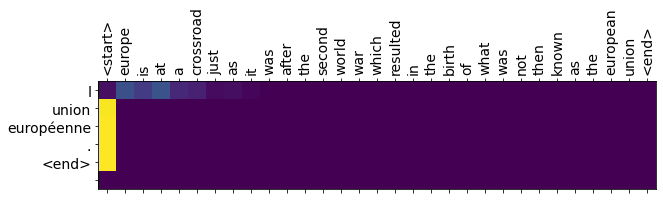

In [54]:
# trying to predict last sentence of validation set
translate(f"europe is at a crossroad just as it was after the second world war which resulted in the birth of what was not then known as the european union")

In [42]:
# predicting another sentence of validation set
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_val[3])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_val[3])

Input Language; index to word mapping
2 ----> <start>
11 ----> i
188 ----> m
19 ----> not
1 ----> the
80 ----> only
52 ----> one
77 ----> who
21 ----> s
3789 ----> obsessed
23 ----> with
14 ----> this
275 ----> whole
159 ----> year
306 ----> thing
3 ----> <end>

Target Language; index to word mapping
2 ----> <start>
23 ----> je
29 ----> ne
95 ----> suis
28 ----> pas
6 ----> la
334 ----> seule
11 ----> à
42 ----> être
15078 ----> obsédée
33 ----> par
37 ----> cette
755 ----> affaire
12 ----> des
165 ----> ans
1 ----> .
3 ----> <end>


Input: <start> i m not the only one who s obsessed with this whole year thing <end>
Predicted translation: je voudrais dire que nous avons pas de la commission , mais je voudrais dire que nous avons pas de la commission , mais je voudrais dire que nous avons pas de la commission , mais je voudrais dire que nous avons pas de la commission , mais je voudrais dire que nous avons pas de la commission , mais je voudrais dire que nous avons pas de la commission , mais je voudrais dire que nous avons pas de la commission , mais je voudrais dire que nous avons pas de la commission , mais je voudrais dire que nous avons pas de la commission , mais je voudrais dire que nous 
length of the predicted translation : 114


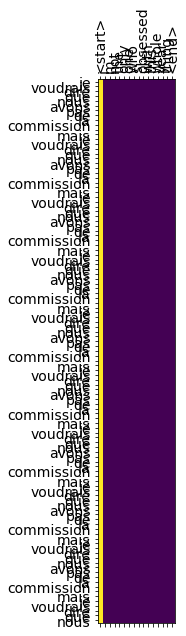

In [55]:
# Here we see some not so good behavior of the model, the lenght of the predicted translation is 114 because its max lenght is 113 and the model adds a space afterwards
translate(f"i'm not the only one who's obsessed with this whole year thing")

In [44]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_val[1])

Input Language; index to word mapping
2 ----> <start>
25 ----> will
63 ----> he
1949 ----> pass
1 ----> the
3402 ----> examination
11 ----> i
102 ----> am
1220 ----> afraid
19 ----> not
3 ----> <end>


Input: <start> will he pass the examination i am afraid not <end>
Predicted translation: il est pas de la commission , et les états membres . <end> 
length of the predicted translation : 14


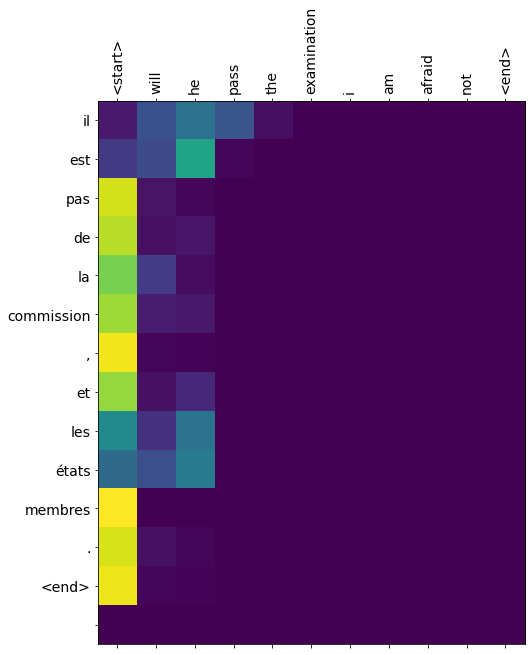

In [56]:
translate(f"will he pass the examination i am afraid not")

## Model 2 (with pre-trained word2vec embedings)

Please refer to the word_embeddings.ipynb for the code. Note that two word2vec models were trained. One where each sentence doesn't have a \<start> and \<end> tag and one where each sentence does. Qualitatively, we see that the word2vec model with the tags performs better than the one without.

In [87]:
# loading word2vec embeddings
from gensim.models import KeyedVectors
# model without tag
w2v = KeyedVectors.load('data/wordvectors')
# model with tag
w2v_wtag = KeyedVectors.load('data/wordvectors_wtag')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# embedding matrix

def create_embedding_matrix(inp_lang, embedding_dim, embedding_model):
  print('Preparing embedding matrix')
  oov = 0
  oov_words = []
  vocab_size = len(inp_lang.word_index) + 1
  word_index = inp_lang.word_index
  embedding_matrix = np.zeros((vocab_size, embedding_dim))
  for word, i in word_index.items():
    if word not in embedding_model:
      # we can investigate the oov words
      oov_words.append(word)
      oov += 1
      # words not found in embedding_model will all be set to 0
      embedding_vector = np.zeros((100,))
    else:
      embedding_vector = embedding_model.get_vector(word)
    embedding_matrix[i] = embedding_vector
  print(f"Found {oov} out-of-vocabulary words (not present in the embedding model)")
  return embedding_matrix

In [68]:
embedding_matrix = create_embedding_matrix(inp_lang, embedding_dim=100, embedding_model=w2v_wtag)

Preparing embedding matrix
Found 433 out-of-vocabulary words (not present in the embedding model)


In [69]:
print(np.shape(embedding_matrix))

(13240, 100)


In [0]:
# Encoder with GRU gates and pre-trained embedding with word2vec
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, embedding_matrix):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    # could modify the embeddings for pre-trained embeddings
    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [71]:
# specify the embedding dim to be equal to the embedding dim chosen for word embeddings
embedding_dim = 100
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, embedding_matrix)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (24, 94, 512)
Encoder Hidden state shape: (batch size, units) (24, 512)


In [72]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (24, 512)
Attention weights shape: (batch_size, sequence_length, 1) (24, 94, 1)


In [73]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (24, 16781)


In [0]:
# Optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [0]:
# checkpoints do not want to override previous model
checkpoint_dir_w2v_wtg = './training_checkpoints_word2vec_wtg'
checkpoint_prefix = os.path.join(checkpoint_dir_w2v_wtg, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [77]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.1810
Epoch 1 Batch 100 Loss 1.2537
Epoch 1 Batch 200 Loss 1.3468
Epoch 1 Batch 300 Loss 1.4124
Epoch 1 Batch 400 Loss 1.4910
Epoch 1 Loss 1.3270
Time taken for 1 epoch 258.39566230773926 sec

Epoch 2 Batch 0 Loss 1.1281
Epoch 2 Batch 100 Loss 1.4790
Epoch 2 Batch 200 Loss 1.1024
Epoch 2 Batch 300 Loss 1.1577
Epoch 2 Batch 400 Loss 1.3879
Epoch 2 Loss 1.1795
Time taken for 1 epoch 142.83874344825745 sec

Epoch 3 Batch 0 Loss 1.2853
Epoch 3 Batch 100 Loss 1.2729
Epoch 3 Batch 200 Loss 1.0316
Epoch 3 Batch 300 Loss 1.2767
Epoch 3 Batch 400 Loss 1.0187
Epoch 3 Loss 1.0952
Time taken for 1 epoch 142.24177050590515 sec

Epoch 4 Batch 0 Loss 0.9993
Epoch 4 Batch 100 Loss 0.9069
Epoch 4 Batch 200 Loss 1.3801
Epoch 4 Batch 300 Loss 0.8809
Epoch 4 Batch 400 Loss 1.1138
Epoch 4 Loss 1.0203
Time taken for 1 epoch 142.94934105873108 sec

Epoch 5 Batch 0 Loss 1.0909
Epoch 5 Batch 100 Loss 1.0787
Epoch 5 Batch 200 Loss 0.9271
Epoch 5 Batch 300 Loss 1.1905
Epoch 5 Batch 400 Loss

Here we load the trained GRU with attention with pre-trained embeddings with start and end tag.

In [83]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir_w2v_wtg))

Input: <start> europe is at a crossroad just as it was after the second world war which resulted in the birth of what was not then known as the european union <end>
Predicted translation: l europe est en un peu de la région . <end> 
length of the predicted translation : 12


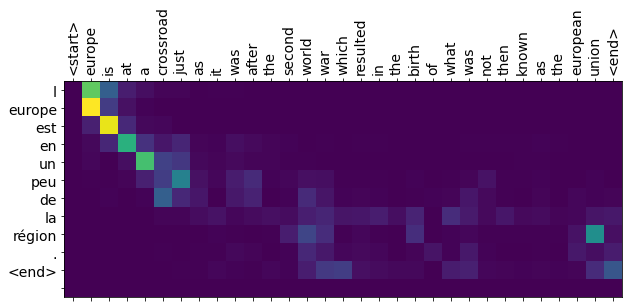

In [84]:
# trying to predict first sentence of validation set with word2vec_wtg model
translate(f"europe is at a crossroad just as it was after the second world war which resulted in the birth of what was not then known as the european union")

We can see that the model with pre-trained embeddings with tags if better than the model without pre-trained embeddings (refer to the plot with predicted length of 114)

Input: <start> i m not the only one who s obsessed with this whole year thing <end>
Predicted translation: je n ai pas le monde , qui a été de cette année . <end> 
length of the predicted translation : 16


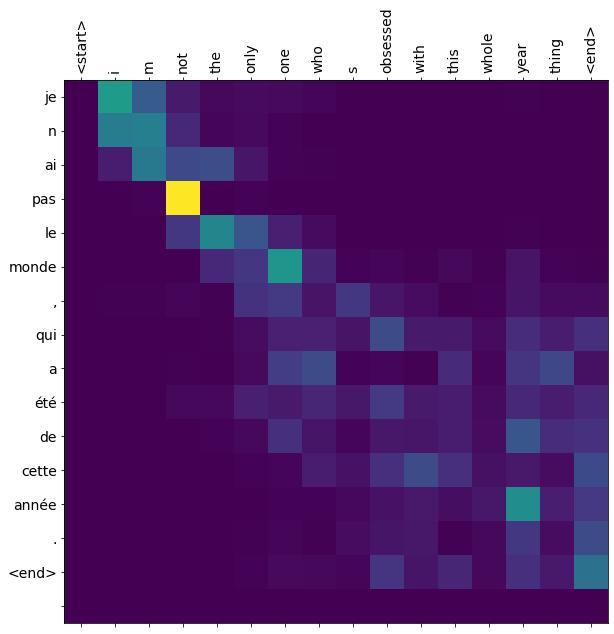

In [85]:
translate(f"i'm not the only one who's obsessed with this whole year thing")

Input: <start> will he pass the examination i am afraid not <end>
Predicted translation: doit elle t il va dire à la table des potins , je ne suis pas . <end> 
length of the predicted translation : 19


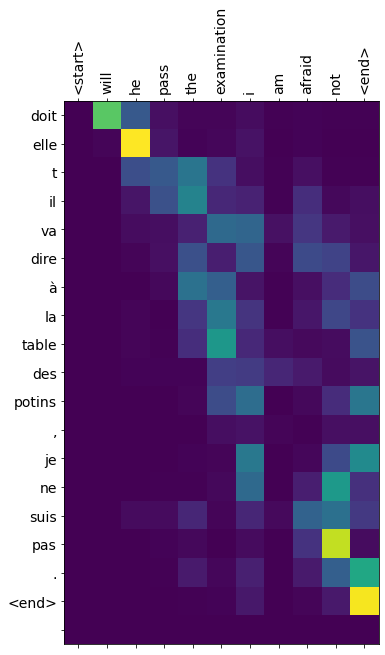

In [86]:
translate(f"will he pass the examination i am afraid not")

Here we load the previously trained GRU with attention with pre-trained embeddings without start and end tag.

In [89]:
# compared to predicting first sentence of validation set with word2vec model (without <start> and <end> for each sentence)

# checkpoints
checkpoint_dir_w2v = './training_checkpoints_word2vec'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir_w2v))

Input: <start> europe is at a crossroad just as it was after the second world war which resulted in the birth of what was not then known as the european union <end>
Predicted translation: urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consultatif attaque urss consult

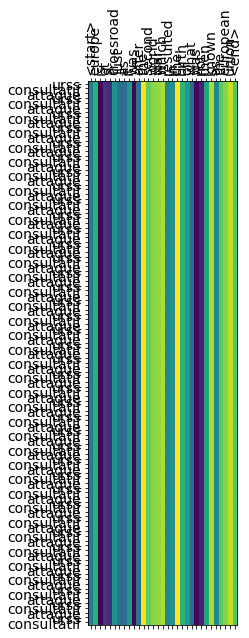

In [90]:
translate(f"europe is at a crossroad just as it was after the second world war which resulted in the birth of what was not then known as the european union")

We can cleary see that there is some problem when we don't add the \<start> and \<end> tag. We can deduce that it comes from our evaluate function since it stops predicting words when the model predicts the end token. However, with this model it doesn't seem to predict it so the lenght of the predicted sentence is set to its maximum.

Input: <start> i m not the only one who s obsessed with this whole year thing <end>
Predicted translation: stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception biens stag conception 
length of the predicted translation : 114


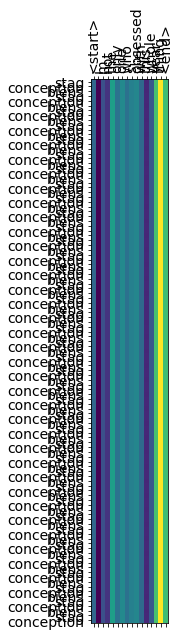

In [91]:
translate(f"i'm not the only one who's obsessed with this whole year thing")

Input: <start> will he pass the examination i am afraid not <end>
Predicted translation: gestionnaires détachés interagissons respectez allure demandez sortant parties existerais higgs publiée détachés interagissons respectez allure demandez sortant parties existerais higgs publiée détachés interagissons respectez allure demandez sortant parties existerais higgs publiée détachés interagissons respectez allure demandez sortant parties existerais higgs publiée détachés interagissons respectez allure demandez sortant parties existerais higgs publiée détachés interagissons respectez allure demandez sortant parties existerais higgs publiée détachés interagissons respectez allure demandez sortant parties existerais higgs publiée détachés interagissons respectez allure demandez sortant parties existerais higgs publiée détachés interagissons respectez allure demandez sortant parties existerais higgs publiée détachés interagissons respectez allure demandez sortant parties existerais higgs publi

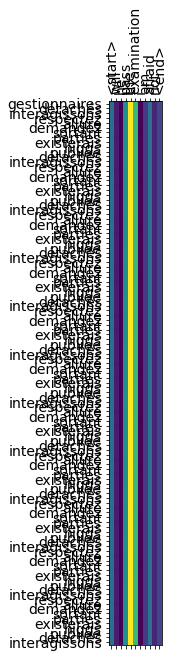

In [92]:
translate(f"will he pass the examination i am afraid not")

Overall the best model so far is the GRU with attention with the pre-trained word embeddings from the unaligned corpus with the added start and end token for each sentence. 